In [58]:
import numpy as np
# from function import *
import matplotlib.pyplot as plt
from itertools import product


speed_uav =30
speed_ugv =10
survey_time = 1/6
waypoints = [(12, 50), (17, 50), (20, 49),(20, 46)]
plan_output = "0 -> 1 -> 2 -> 3 -> 0"
radii = [4]
ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
ordered_points.append(ordered_points[0])

In [59]:
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import product

def draw_circle(ax, center, radius):
    circle = plt.Circle(center, radius, fill=False, edgecolor='b', linewidth=1.5)
    ax.add_patch(circle)

def angle_between_points(p1, p2):
    return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

def point_on_circle(center, angle, radius):
    return (center[0] + radius * np.cos(angle), center[1] + radius * np.sin(angle))


def compute_distance(point1, point2):
    try:
        x1, y1 = point1
        x2, y2 = point2
        return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    except TypeError:
        print(f"Error with points: {point1} and {point2}")
        raise

def format_list_to_decimal(numbers_list):
    """Format each number in the list to two decimal places."""
    return ["{:.2f}".format(num) for num in numbers_list]


def find_meeting_point_with_survey_final(center,radius, ugv_start, ugv_end, speed_ugv, speed_uav, survey_time):
    """
    Final function to calculate the meeting point of UGV and UAV on the chord considering survey time.
    
    Parameters:
    - radius: Radius of the circle.
    - ugv_start: Starting point of UGV.
    - ugv_end: Ending point of UGV.
    - speed_ugv: Speed of UGV.
    - speed_uav: Speed of UAV.
    - survey_time: Time of survey the point
    
    Returns:
    - Meeting point of UGV and UAV.
    - Wait time for UGV (if any).
    """
    
    # Calculating the length of the chord
    chord_length = np.sqrt((ugv_end[0] - ugv_start[0])**2 + (ugv_end[1] - ugv_start[1])**2)
    
    # Distance traveled by UGV when UAV reaches the center and finishes survey
    distance_ugv_traveled = speed_ugv * ((radius / speed_uav) + survey_time)
    
    # Remaining distance on the chord for UGV
    remaining_distance = chord_length - distance_ugv_traveled
    
    # Time taken by UAV and UGV to meet on the chord after UAV finishes survey
    time_to_meet = remaining_distance / (speed_uav + speed_ugv)
    
    # Total distance traveled by UGV on the chord till they meet
    total_distance_ugv = distance_ugv_traveled + speed_ugv * time_to_meet
    
    # Coordinates of the meeting point on the chord
    x_meeting = ugv_start[0] + (total_distance_ugv / chord_length) * (ugv_end[0] - ugv_start[0])
    y_meeting = ugv_start[1] + (total_distance_ugv / chord_length) * (ugv_end[1] - ugv_start[1])
    
    # Check if meeting point is outside the circle
    distance_from_center = np.sqrt((x_meeting - center[0])**2 + (y_meeting - center[1])**2)
    
    wait_time = 0  # Default wait time
    
    if distance_from_center > radius:
        # print("yes",{distance_from_center})
        # Set the meeting point to be the UGV end location
        x_meeting, y_meeting = ugv_end[0], ugv_end[1]
        
        # Calculate distance UGV traveled to get to the end point
        distance_ugv_traveled = chord_length
        
        # Calculate the time taken by UGV to reach the end point
        time_ugv = distance_ugv_traveled / speed_ugv
        
        # Time taken by UAV to reach the UGV end point from the circle's center after survey
        distance_uav_traveled = radius*2
        time_uav = (distance_uav_traveled / speed_uav) + survey_time
        
        # Calculate the wait time for UGV
        wait_time = time_uav - time_ugv
    
    return (x_meeting, y_meeting), wait_time





In [60]:
def compute_ordered_points(plan_output, waypoints):
    ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
    ordered_points.append(ordered_points[0])
    return ordered_points

def initialize_plot(ordered_points):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(*zip(*ordered_points))
    return fig, ax

def compute_paths_for_radius(ordered_points, radius_combination, speed_ugv, speed_uav, survey_time):
    UGV_outer_path = [ordered_points[0]]
    UGV_path = [ordered_points[0]]
    UAV_path = []
    # UAV_distances = []
    UGV_inter_distances = []
    
    # Main logic to compute paths based on radius_combination
    # This is a placeholder for now. We'll populate this in the next steps.
    
    return UGV_path, UAV_path, UGV_outer_path, UGV_inter_distances




def compute_non_overlapping_pairwise_distances(path):
    """Compute the distances between each non-overlapping pair of points in the given path."""
    distances = []
    for sub_path in path:
        for i in range(0, len(sub_path) - 1, 2):
            # Validate the points before computing the distance
            if isinstance(sub_path[i], (list, tuple)) and len(sub_path[i]) == 2 and \
               isinstance(sub_path[i+1], (list, tuple)) and len(sub_path[i+1]) == 2:
                distances.append(compute_distance(sub_path[i], sub_path[i+1]))
                # print(sub_path[i+1]) 
    return distances

    
def compute_tripwise_distances(path):
    """Compute the distances for each set of three points in the given path."""
    distances = []
    print(path)
    for i in range(0, len(path) - 2, 3):
        
        distance_trip = compute_distance(path[i], path[i+1]) + compute_distance(path[i+1], path[i+2])
        distances.append(distance_trip)
    return distances

def circles_overlap(center1, radius1, center2, radius2):
    """Check if two circles overlap."""
    distance_between_centers = compute_distance(center1, center2)
    return distance_between_centers < (radius1 + radius2)
    
def remove_empty_lists(lst):
    return [sublist for sublist in lst if sublist]

In [61]:
def compute_optimized_paths_for_radius_updated_v3(ordered_points, radius_combination, speed_ugv, speed_uav, survey_time):
    UGV_outer_path = []
    UGV_path = [ordered_points[0]]
    UAV_path = []
    UGVD_inter_without_drone = []
    UGVD_inter_with_drone = []
    chord_end = None
    prev_chord_end = None
    final_wait_set = []
    for i, point in enumerate(ordered_points[:-1]):
        current_radius = radius_combination[i % len(radius_combination)]
        
        # Exclude the start and end points from circles
        if 0 < i < len(ordered_points) - 2:
            angle = angle_between_points(ordered_points[i-1], ordered_points[i])
            nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
            chord_start = point_on_circle(ordered_points[i], angle - np.pi, current_radius)
            chord_end = point_on_circle(ordered_points[i], nextangle, current_radius)
            
            if prev_chord_end and i > 1 and circles_overlap(ordered_points[i], current_radius, ordered_points[i-1], radius_combination[(i-1) % len(radius_combination)]):
                chord_start = prev_chord_end

            final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(
                ordered_points[i], current_radius, chord_start, chord_end, 
                speed_ugv, speed_uav, survey_time
            )
            final_wait_set.append(final_wait_time)
            # Update paths based on the provided structure
            if chord_start:
                UAV_path.append([chord_start, point, final_meeting_point])
                UGV_path.append(chord_start)
                
                # Update UGV_outer_path as per the new structure
                if i == 1:
                    UGV_outer_path.append([ordered_points[0], chord_start])
                else:
                    UGV_outer_path.append([prev_chord_end, chord_start])
                
            if chord_end:
                UGV_path.append(chord_end)
                
            UGVD_inter_without_drone.append(compute_distance(chord_start, final_meeting_point))
            UGVD_inter_with_drone.append(compute_distance(final_meeting_point, chord_end))
            
            prev_chord_end = chord_end
            
    # Adding the last point to the paths
    UGV_path.append(ordered_points[-1])
    UGV_outer_path.append([chord_end,ordered_points[-1]])
    return UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone,final_wait_set

# Note: The function compute_distance, find_meeting_point_with_survey_final, angle_between_points, 
# point_on_circle, and circles_overlap are not provided, so if you plan to run this function, ensure they are defined.


In [62]:
UGVdistances = []
UAV_total_distances = []
UGV_outer_path_distances = []
UAV_distances_set = []
ordered_points = compute_ordered_points(plan_output, waypoints)
for radius_combination in product(radii, repeat=len(waypoints)-1):
    print(f"radius_combination:{radius_combination}")
    UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone,UGVD_inter_with_drone,final_wait_time= compute_optimized_paths_for_radius_updated_v3(ordered_points, radius_combination, speed_ugv, speed_uav, survey_time)
    # print(f"UAV_path:{UAV_path}")
    # # Plotting the updated paths
    # # plot_updated_paths_with_circles(ordered_points,UAV_path, UGV_outer_path,radius_combination)
    print(f"UGV_outer_path:{UGV_outer_path}")
    # print(f"UGV_path:{UGV_path}")
    # print(f"final_wait_time:{final_wait_time}")
    # print(f"UGVD_inter_with_drone:{UGVD_inter_with_drone}")
    # print(f"UGVD_inter_without_drone:{UGVD_inter_with_drone}")

    total_wait_time = 0
    UGV_total_distance = 0
    for j in range(len(final_wait_time)):
        total_wait_time+=final_wait_time[j]
    for i in range(len(UGV_path)-1):
        x1, y1 = UGV_path[i]
        x2, y2 = UGV_path[i+1]
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        UGV_total_distance += distance

    total_time = total_wait_time + UGV_total_distance/speed_ugv
    print(f"total_time:{total_time:.2f} \n")



radius_combination:(4, 4, 4)
UGV_outer_path:[[(12, 50), (13.0, 50.0)], [(20.794733192202056, 48.73508893593265), (20.794733192202056, 48.73508893593265)], [(20.0, 45.0), (20.0, 45.0)], [(16.422291236000337, 47.78885438199983), (12, 50)]]
total_time:2.22 



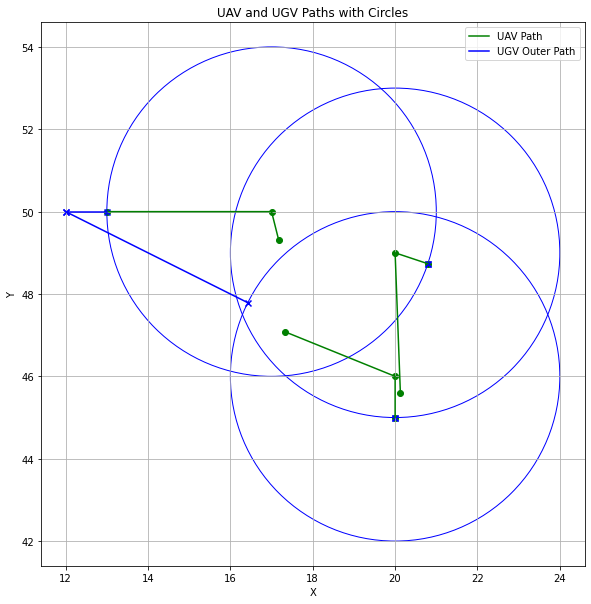

In [63]:
def draw_circle(ax, center, radius, *args, **kwargs):
    circle = plt.Circle(center, radius, fill=False, *args, **kwargs)
    ax.add_patch(circle)

def plot_updated_paths_with_circles(UAV_path, UGV_outer_path, ordered_points, radius_combination):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot UAV_path
    for segment in UAV_path:
        ax.plot(*zip(*segment), 'g-', label='UAV Path')
        ax.scatter(*zip(*segment), color='g', marker='o')
    
    # Plot UGV_outer_path without connecting segments to each other
    for segment in UGV_outer_path:
        ax.plot(*zip(*segment), 'b-', label='UGV Outer Path')
        ax.scatter(segment[0][0], segment[0][1], color='b', marker='x')  # Plotting start of the segment
        ax.scatter(segment[1][0], segment[1][1], color='b', marker='x')  # Plotting end of the segment
        
    # Draw circles
    for i, point in enumerate(ordered_points[:-1]):
        if 0 < i < len(ordered_points) - 2:
            current_radius = radius_combination[i % len(radius_combination)]
            draw_circle(ax, point, current_radius, color='b', linestyle='-')
    
    # Labels and Title
    ax.set_title("UAV and UGV Paths with Circles")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)
    
    # Handling legends to avoid repetition
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(dict.fromkeys(labels))
    unique_handles = [handles[labels.index(lab)] for lab in unique_labels]
    ax.legend(unique_handles, unique_labels, loc="best")
    ax.set_aspect('equal', adjustable='box')
    plt.show()

# Given ordered points


# Plotting the updated paths with circles
plot_updated_paths_with_circles(UAV_path, UGV_outer_path, ordered_points, radius_combination)


In [64]:
def plot_updated_paths(ordered_points,UAV_path, UGV_outer_path,current_radius):
    current_radius = radius_combination[i % len(radius_combination)]
    fig, ax = plt.subplots(figsize=(10, 10))
    for i, point in enumerate(ordered_points[:-1]):
        print(f"Point {i}: {point}")
        
        ax.annotate(i, (point[0] + 0.5, point[1] + 0.5))
        draw_circle(ax, point, current_radius)
    # Plot UAV_path
    for segment in UAV_path:
        ax.plot(*zip(*segment), 'g-', label='UAV Path')
        ax.scatter(*zip(*segment), color='g', marker='o')
    
    # Plot UGV_outer_path without connecting segments to each other
    for segment in UGV_outer_path:
        ax.plot(*zip(*segment), 'b-', label='UGV Outer Path')
        ax.scatter(segment[0][0], segment[0][1], color='b', marker='x')  # Plotting start of the segment
        ax.scatter(segment[1][0], segment[1][1], color='b', marker='x')  # Plotting end of the segment
    
    # Labels and Title
    ax.set_title("UAV and UGV Paths")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)
    
    # Handling legends to avoid repetition
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(dict.fromkeys(labels))
    unique_handles = [handles[labels.index(lab)] for lab in unique_labels]
    ax.legend(unique_handles, unique_labels, loc="best")
    
    plt.show()





In [65]:
# def compute_optimized_paths_for_radius_updated_v2(ordered_points, radius_combination, speed_ugv, speed_uav, survey_time):
#     UGV_outer_path = [[ordered_points[0]]]
#     UGV_path = [ordered_points[0]]
#     UAV_path = []
#     UGVD_inter_without_drone = [[]]
#     UGVD_inter_with_drone = [[]]
#     chord_end = None
#     prev_chord_end = None
    
#     for i, point in enumerate(ordered_points[:-1]):
#         current_radius = radius_combination[i % len(radius_combination)]
        
#         # Exclude the start and end points from circles
#         if 0 < i < len(ordered_points) - 2:
#             angle = angle_between_points(ordered_points[i-1], ordered_points[i])
#             nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
#             chord_start = point_on_circle(ordered_points[i], angle - np.pi, current_radius)
#             chord_end = point_on_circle(ordered_points[i], nextangle, current_radius)
            
#             if prev_chord_end and i > 1 and circles_overlap(ordered_points[i], current_radius, ordered_points[i-1], radius_combination[(i-1) % len(radius_combination)]):
#                 chord_start = prev_chord_end
#                 # print("Checked",chord_start)
            
#             final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(
#                 ordered_points[i], current_radius, chord_start, chord_end, 
#                 speed_ugv, speed_uav, survey_time
#             )
            
#             UGVD_inter_without_drone[-1].append(compute_distance(chord_start,final_meeting_point))
#             UGVD_inter_with_drone[-1].append(compute_distance(final_meeting_point,chord_end))
            
#             UGV_outer_path[-1].append(chord_start)
            
#             UAV_path[-1].extend([chord_start, ordered_points[i], final_meeting_point])
#             UGV_path[-1].append(final_meeting_point)
            
#             if i > 0 and chord_end:
#                 UGV_outer_path[i].append(chord_end)
                
#             prev_chord_end = chord_end
#         # if chord_end:
#         #     UGV_outer_path[].append(ordered_points[-1])
#         # Initialize new sub-lists for the next iteration
#         UGV_outer_path.append([])
#         UGV_path.append([])
#         UAV_path.append([])
#         UGVD_inter_without_drone.append([])
#         UGVD_inter_with_drone.append([])
    
#     # Remove the last empty sub-lists
#     UGV_path.pop()
#     UAV_path = remove_empty_lists(UAV_path)
#     # print(UAV_path)
#     UGVD_inter_without_drone.pop()
#     UGVD_inter_with_drone.pop()
    
#     # Adding the last point to the paths
#     # if chord_end:
#     #     UGV_outer_path.append(ordered_points[-1])
#     UGV_path[-1].append(ordered_points[-1])
#     print("UGV_outer_path:",UGV_outer_path)
    
#     return UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone


In [66]:


def plot_solution_final_refined_v2(waypoints, plan_output, radii, speed_ugv, speed_uav, survey_time, plot_graph=True):
    UGVdistances = []
    UAV_total_distances = []
    UGV_outer_path_distances = []
    UAV_distances_set = []
    ordered_points = compute_ordered_points(plan_output, waypoints)
    
    for radius_combination in product(radii, repeat=len(waypoints)-1):
        
        if plot_graph:
            fig, ax = initialize_plot(ordered_points)
            
        UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone,UGVD_inter_with_drone = compute_optimized_paths_for_radius_updated_v2(
            ordered_points, radius_combination, speed_ugv, speed_uav, survey_time)
        
        if plot_graph:
            visualize_paths_updated(ax, ordered_points, UGV_path, UAV_path, UGV_outer_path, radius_combination)
            plt.show()
        
        # Calculating the UGV_outer_path distance
        UGV_outer_distance = compute_non_overlapping_pairwise_distances(UGV_outer_path)
        UGV_outer_path_distances.append(format_list_to_decimal(UGV_outer_distance))
        
        if plot_graph:
            UGV_distance = sum(np.linalg.norm(np.array(UGV_path[i]) - np.array(UGV_path[i+1])) 
                               for i in range(len(UGV_path) - 1))
            UGVdistances.append(UGV_distance)
            
            # print(f"UGV Outer Path Distance: {UGV_outer_distance:.2f}")
        # print("UAV_path",UAV_path)
        
        for k in range(len(UAV_path)):
            UAV_distances =  format_list_to_decimal(compute_tripwise_distances(UAV_path[k]))
            UAV_distances_set.append(UAV_distances)
        # UAV_distances_set = format_list_to_decimal(compute_tripwise_distances(UAV_path))
        print(UAV_distances_set)
    return  UGVD_inter_without_drone,UGVD_inter_with_drone, UAV_distances_set, UGV_outer_path_distances


In [67]:
def visualize_paths_updated(ax, ordered_points, UGV_path, UAV_path, UGV_outer_path, radius_combination):
    for i, point in enumerate(ordered_points[:-1]):
        print(f"Point {i}: {point}")
        
        ax.annotate(i, (point[0] + 0.5, point[1] + 0.5))
        
        if 0 < i < len(ordered_points) -2:
            # Extract required details for plotting
            current_radius = radius_combination[i % len(radius_combination)]
            chord_start = UAV_path[i-1][0]  # Using the UGV_outer_path to get the chord start
            final_meeting_point = UAV_path[i-1][2]  # Using the UAV path to get the meeting point
            chord_end = UGV_outer_path[i] # Using the UGV_outer_path to get the chord end
            print(f"UAV_path:{UAV_path}")
            print(f"UGV_outer_path:{UGV_outer_path}")
            # print(f"Current Radius: {current_radius}")
            # print(f"Chord Start: {chord_start}")
            # print(f"Final Meeting Point: {final_meeting_point}")
            # print(f"Chord End: {chord_end}")
            
            # Plotting details
            draw_circle(ax, point, current_radius)
            plt.scatter(point[0], point[1], color='g', label='Interest Point (Half-way for UAV)')
            plt.scatter(chord_start[0], chord_start[1], color='r', label='Takeoff Point (UGV & UAV split)')
            
            ax.plot([final_meeting_point[0], chord_end[0]], 
                    [final_meeting_point[1], chord_end[1]], 
                    'm-', label='Path of UGV with Drone')
            ax.plot([chord_start[0], final_meeting_point[0]], 
                    [chord_start[1], final_meeting_point[1]], 
                    color='r', linestyle='-', label='Path of UGV without Drone')
            plt.scatter(final_meeting_point[0], final_meeting_point[1], 
                        color='y', marker='X', s=100, label='Meeting Point')

    # Plot each pair of points in the UGV_outer_path list
    # print(f"UGV Outer Path: {UGV_outer_path}")
    # for i in range(0, len(UGV_outer_path), 2):
        # ax.plot(*zip(*UGV_outer_path[i:i+2]), color='b', linestyle='-', marker='o')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'TSP Solution, radii = {radius_combination}')
    plt.grid()
    plt.axis('equal')

# Note: The function draw_circle is not provided, so if you plan to run this function, ensure draw_circle is defined.


NameError: name 'compute_optimized_paths_for_radius_updated_v2' is not defined

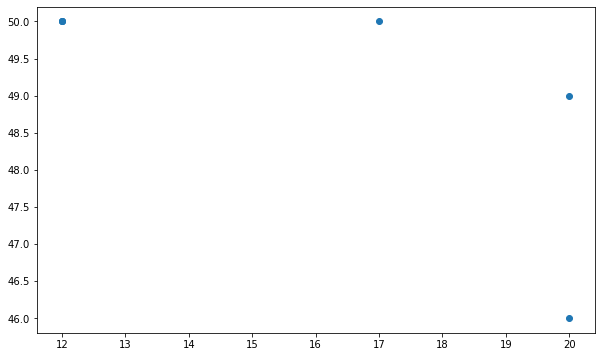

In [68]:
# Sample run again
UGVD_inter_without_drone,UGVD_inter_with_drone, UAV_distances_set, UGV_outer_path_distances= plot_solution_final_refined_v2(waypoints, plan_output, radii, speed_ugv, speed_uav, survey_time, plot_graph=True)
